# Import packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import sys

# Define own functions

In [24]:
def centrality_norm_diff(candidate_dict,true_dict):
    
    """Computes the difference of the centrality scores
    given 2 dictionaries"""
    
    score = 0
    for key, val in candidate_dict.items():
        score += np.linalg.norm(val-true_dict[key])
        
        
    return score

In [39]:
def network_preprocessing(date,method,ts_type,dy_threshold):
    
    """Import the network adjacency matrix from a .csv file, converts it into a networkx
    diGraph object"""
    
    # Convert date to string
    final_date_transformed = date.replace("-","_")
    
    
    # Import file
    filename = "./Data/Estimated_networks/" +\
                  method+"_"+ts_type+"_"+final_date_transformed+".csv"

    if (method == "DY") & (date != "2020-03-16"):
        network_matrix = np.genfromtxt(filename,
                              delimiter=',',skip_header = 1,usecols = np.arange(1,11),
                                   skip_footer=1)
        
        # Make the diagonal zero
        np.fill_diagonal(network_matrix, 0)
        
        # Delete link if the edge weight is too small in case of DY
        network_matrix[network_matrix<dy_threshold] = 0
        
        # Normalize values
        network_matrix = network_matrix / 100
        
        #print(network_matrix)
        
    else:
        network_matrix = np.genfromtxt(filename,
                              delimiter=',',skip_header = 1,usecols = np.arange(1,11))
    
    
    # Convert it into networkX object
    network = nx.from_numpy_matrix(network_matrix, create_using=nx.DiGraph)
    
    return network

In [40]:
filename = "./Data/Estimated_networks/DY_return_2020_03_16.csv"

network_matrix = np.genfromtxt(filename,
                              delimiter=',',skip_header = 1,usecols = np.arange(1,11))

In [41]:
network_matrix

array([[0.12541492, 0.09612306, 0.10261234, 0.10094706, 0.09330903,
        0.10158319, 0.10467892, 0.09839159, 0.08983902, 0.08710087],
       [0.10336034, 0.11110192, 0.10643676, 0.10231514, 0.0926414 ,
        0.09671216, 0.1090941 , 0.09966962, 0.08732143, 0.09134714],
       [0.10595209, 0.10241148, 0.11179408, 0.10155645, 0.09286669,
        0.09666317, 0.10886946, 0.0990651 , 0.08746111, 0.09336038],
       [0.10561447, 0.09981801, 0.10294506, 0.11432934, 0.09305539,
        0.09909244, 0.10715088, 0.09820751, 0.08848402, 0.09130288],
       [0.1072104 , 0.09512062, 0.10169435, 0.09815892, 0.11585562,
        0.09201631, 0.10966279, 0.09988747, 0.0892035 , 0.09119002],
       [0.10984821, 0.10020612, 0.10411819, 0.10213176, 0.09192883,
        0.11344561, 0.10466703, 0.09731887, 0.0871227 , 0.08921268],
       [0.10184744, 0.09959061, 0.10394892, 0.10084719, 0.09581673,
        0.09393018, 0.12026988, 0.10194548, 0.0869292 , 0.09487436],
       [0.10366475, 0.09695844, 0.1020230

In [42]:
def network_matrix_preprocessing(date,method,ts_type,dy_threshold):
    
    """Import the network adjacency matrix from a .csv file, converts it into a numpy array"""
    
    # Convert date to string
    final_date_transformed = date.replace("-","_")
    
    
    # Import file
    filename = "./Data/Estimated_networks/" +\
                  method+"_"+ts_type+"_"+final_date_transformed+".csv"

    if (method == "DY") & (date != "2020-03-16"):
        network_matrix = np.genfromtxt(filename,
                              delimiter=',',skip_header = 1,usecols = np.arange(1,11),
                                   skip_footer=1)
        
        # Make the diagonal zero
        np.fill_diagonal(network_matrix, 0)
        
        # Delete link if the edge weight is too small in case of DY
        network_matrix[network_matrix<dy_threshold] = 0
        
        # Normalize values
        network_matrix = network_matrix / 100
        
        #print(network_matrix)
        
    else:
        network_matrix = np.genfromtxt(filename,
                              delimiter=',',skip_header = 1,usecols = np.arange(1,11))
    
    
    # Convert it into networkX object
    network = np.asarray(network_matrix)
    
    return network

In [43]:
def network_robustness_check(dates,method,ts_type,dy_threshold):
    
    """Creates the adjacency matrix with the specified parameters for 2 different dates and computes
    the Frobenius-norm of the difference of the matrices to check persistence/robustness of results"""


    
    # Get the adjacency matrix of the estimated networks
    network1 = network_matrix_preprocessing(dates[0],method,ts_type,dy_threshold)


    network2 = network_matrix_preprocessing(dates[1],method,ts_type,dy_threshold)
    
    # Get difference
    diff = np.linalg.norm(network1-network2)
    
    return diff

In [44]:
def centrality_ranking_df(centrality_type,networks,varnames,asset_sizes=None,cross_holding_network=None):
    
    """Creates a dataframe with the sorted centrality of stocks
    from different methods"""
    
    # Add the cross-holding network to the dictionary (optional)
    if cross_holding_network is not None:
        networks['CH'] = cross_holding_network
        
    
    
    # Loop over different methods and their networks
    for key,val in networks.items():
        
        print(key)
        
    
        if centrality_type == "katz-bonacich":

            centrality_dict = nx.katz_centrality(val)     
            ticker_names = [varnames[k] for k, v in sorted(centrality_dict.items(),
                                                     key=lambda item: item[1],reverse=True)]
            
        elif centrality_type == "betweenness":
            
            centrality_dict = nx.betweenness_centrality(val)
            ticker_names = [varnames[k] for k, v in sorted(centrality_dict.items(),
                                                     key=lambda item: item[1],reverse=True)]   
            
        elif centrality_type == "degree":
            
            centrality_dict = nx.degree_centrality(val)
            ticker_names = [varnames[k] for k, v in sorted(centrality_dict.items(),
                                                     key=lambda item: item[1],reverse=True)] 
            
        elif centrality_type == "eigenvector":
            
            centrality_dict = nx.eigenvector_centrality(val)
            ticker_names = [varnames[k] for k, v in sorted(centrality_dict.items(),
                                                     key=lambda item: item[1],reverse=True)] 
            
        elif centrality_type == "closeness":
            
            centrality_dict = nx.closeness_centrality(val)
            ticker_names = [varnames[k] for k, v in sorted(centrality_dict.items(),
                                                     key=lambda item: item[1],reverse=True)] 
            
        else:
            ticker_names = None
            
        networks[key] = ticker_names
        
        
    # Add the asset sizes to the dictionary (optional)
    if asset_sizes is not None:
        networks['AS'] = asset_sizes

    
    # Create dataframe
    df = pd.DataFrame(networks)
    
    return df

In [45]:
def rank_viz(varnames,ranking_df,centrality_type,date,ts_type):
    
    fig = plt.figure(figsize=(8,3.))
    ax = fig.add_subplot(111)
    col = 'white'
    
    cols = ranking_df.columns
    #print(cols)
    #print(varnames)
    
    n = len(varnames)
    d = len(cols)
    palette = iter(sns.color_palette("Paired", n))

    y_max = np.ones(d)*n
    x = np.arange(0,d,1)
    
    names = np.asarray(copy.deepcopy(varnames))
    
    for stock in varnames:
        stock_list = []
        counter = 0
        #print(stock)
        for i in cols:
            #print(i)
            #print(stock)
            
            
            temp = ranking_df[ranking_df[i]==stock].index.values[0]
            
            if counter == 0:
                #print(stock)
                #print(temp)
                names[n-temp-1] = stock

            stock_list.append(temp)
            
            
            
            ax.annotate(str(temp+1), xy=(counter,n - temp), color=col,
                fontsize=8, weight='heavy',
                horizontalalignment='center',
                verticalalignment='center')
            
            counter += 1

        yn = y_max-np.asarray(stock_list)
        #print(yn)

        

        ax.plot(x,yn, color=next(palette), linewidth=5)
        
    palette = iter(sns.color_palette("Paired", n))   
    for stock in varnames:
        stock_list = []
        counter = 0
        for i in cols:
            temp = ranking_df[ranking_df[i]==stock].index.values[0]
            
            stock_list.append(temp)
            
            counter += 1
            
        ax.plot(x,y_max - np.asarray(stock_list), '.', markersize=26, mec='w', mfc=next(palette))
    
    plt.xticks(range(d))
    plt.yticks(np.arange(1,n+1,1))
    plt.gca().get_yaxis().set_ticklabels(names)
    plt.gca().get_xaxis().set_ticklabels(cols)
    ax.set_facecolor('gainsboro')
    plt.tight_layout()
    
    # Convert date to string
    final_date_transformed = date.replace("-","_")
    plt.savefig('./Figures/ranking_comparison_{}_{}_{}.pdf'.format(ts_type,final_date_transformed,
                                                                 centrality_type),dpi=120)
    plt.show()

In [46]:
def workflow_wrapper_function(date,methods,ts_type,dy_threshold,
             centrality_type,varnames,asset_sizes=None,cross_holding_network=None):
    
    """Wrapper function to run the whole workflow"""

    # Create dictionary to store the outputs
    networks = {}

    for method in methods:

        networks[method] = network_preprocessing(date,method,ts_type,dy_threshold)
        
    # Create centrality rankings
    ranking_df = centrality_ranking_df(centrality_type,networks,varnames,varnames_sorted_by_asset,CH_network)
    
    
    # Run the visualisation function
    rank_viz(varnames,ranking_df,centrality_type,date,ts_type)

# Import data

## Cross-holdings

In [47]:
# SPECIFY BY DATE HERE TOO!
CH = pd.read_excel('./Data/nasdaq_normalized_cross_holdings.xlsx')
CH = np.array(CH)

In [48]:
CH.shape

(10, 11)

In [49]:
stock_names = CH[:,0]

CH = CH[:,1:]

In [50]:
CH = np.asarray(CH,dtype=np.float64)

In [51]:
# Convert it into networkX object
CH_network = nx.from_numpy_matrix(CH, create_using=nx.DiGraph)

## Estimated networks

In [52]:
# Parameters
date = "2020-03-16"
ts_type = "return"
dy_threshold = 10.5
method = "DY"

network_preprocessing(date,method,ts_type,dy_threshold)

In [54]:
# Parameters
date = "2020-03-16"
ts_type = "return"
dy_threshold = 10.5

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DAG']

# Create dictionary to store the outputs
networks = {}

for method in methods:
    
    networks[method] = network_preprocessing(date,method,ts_type,dy_threshold)

### Check singularity/invertibility of DY-network

In [57]:
# Parameters
date = "2020-03-16"
ts_type = "volatility_factor_resid"
dy_threshold = 5
method = "DY"

# Preprocessing
DY_network = network_matrix_preprocessing(date,method,ts_type,dy_threshold)

print(DY_network)

[[0.14950412 0.08787907 0.12046753 0.07813825 0.1211929  0.09231183
  0.04780652 0.09674414 0.09711807 0.10883758]
 [0.10500141 0.16172119 0.10957236 0.06787006 0.10608364 0.10091569
  0.03536105 0.09111567 0.10170773 0.12065119]
 [0.11791701 0.07605284 0.15780174 0.08820021 0.12224483 0.09307901
  0.052641   0.09364694 0.09690679 0.10150963]
 [0.10056373 0.0699801  0.11102155 0.15008643 0.12468131 0.09860735
  0.04930005 0.08954541 0.09465151 0.11156256]
 [0.10268582 0.07914586 0.11383674 0.08662961 0.15545646 0.0815004
  0.05404324 0.09986191 0.11122379 0.11561617]
 [0.1099425  0.09020591 0.11406309 0.09162645 0.10959625 0.14738906
  0.03869629 0.08965756 0.09094902 0.11787387]
 [0.09095185 0.07460894 0.1021755  0.0822959  0.11211441 0.0739999
  0.13134658 0.0985838  0.11600605 0.11791707]
 [0.09437687 0.07416143 0.10375624 0.0783325  0.10944424 0.07582058
  0.0558671  0.16332631 0.1291559  0.11575883]
 [0.09168335 0.07980029 0.10466202 0.07312633 0.11427381 0.07435876
  0.05818569 0

In [58]:
# Check whether matrix is singular/or invertible
if np.linalg.cond(DY_network) < 1/sys.float_info.epsilon:
    iinverse = np.linalg.inv(DY_network)
    print(iinverse)
else:
    print("Singular matrix!")

[[21.65167426 -3.15432382 -6.5950651   0.85354589 -6.62811363 -3.02629502
  -0.44396098 -2.25397548  1.20021308 -0.60369922]
 [-2.09755295 12.22473198 -1.65639607  1.65735103 -0.6846893  -4.71807899
   1.14205911 -0.41618314 -2.05637113 -2.39487056]
 [-9.05029904  0.79304034 21.14080964 -2.66846097 -4.99082208 -3.30689418
  -1.50366086 -0.59396304 -0.42902187  1.60927208]
 [-0.47229721  1.36590659 -1.73030933 15.06907342 -6.57074817 -5.19543758
  -0.65020749 -0.15775442  0.39443961 -1.05266544]
 [-2.94699642 -1.46578811 -4.73729118 -3.71236387 23.2485055   0.70632486
  -1.3685163  -2.21998458 -4.27367095 -2.23021893]
 [-4.14426675 -3.43499546 -3.06740326 -4.50974249  0.8137476  17.53201868
   0.99645868 -0.92746196  0.895793   -3.15414801]
 [-0.31596256 -0.58765231 -0.84355999 -1.88920647 -1.68645768  0.56378698
  12.11848815 -1.16782662 -3.454595   -1.7370145 ]
 [-1.46268139 -0.04124012 -1.07893605 -1.44570803 -0.24975717 -0.06690419
  -0.95415197 15.33593245 -8.10059378 -0.93595974]


In [59]:
# Convert it into a networkx object and try to compute eigenvector centrality
network = nx.from_numpy_matrix(DY_network, create_using=nx.DiGraph)
centrality_dict = nx.eigenvector_centrality(network)

## Asset sizes

In [60]:
# Get asset sizes
asset_sizes = pd.read_excel('./Data/asset_sizes.xlsx',index_col=0)

# Inspect dataframe
print(asset_sizes.head())

  stock    year2019
0   JPM  2687379000
1    MS   895429000
2   BAC  2434079000
3     C  1951158000
4   WFC  1927555000


In [61]:
# Sort dataframe by asset size
asset_sizes.sort_values('year2019',inplace=True,ascending=False)

# Reset index
asset_sizes.reset_index(drop=True, inplace=True)

# Inspect dataframe
print(asset_sizes.head())

  stock    year2019
0   JPM  2687379000
1   BAC  2434079000
2     C  1951158000
3   WFC  1927555000
4    TD  1415290000


In [62]:
# Add current index as a new column (rank)
asset_sizes.reset_index(inplace=True)

# Inspect dataframe
print(asset_sizes.head())

   index stock    year2019
0      0   JPM  2687379000
1      1   BAC  2434079000
2      2     C  1951158000
3      3   WFC  1927555000
4      4    TD  1415290000


In [63]:
# Get varnames sorted by asset size
varnames_sorted_by_asset = list(asset_sizes['stock'])

# Inspect list
print(varnames_sorted_by_asset)

['JPM', 'BAC', 'C', 'WFC', 'TD', 'GS', 'MS', 'USB', 'TFC', 'BK']


# Centrality measure comparisons

In [64]:
# Parameters
varnames = ["MS","JPM","BAC","C","WFC","GS","USB","TD","BK","TFC"]
centrality_type = "closeness" #"betweenness" #"katz-bonacich"
cross_holdings = True
asset_sizes = True

# Create centrality rankings
if cross_holdings:
    CH_network = CH_network
else:
    CH_network = None
    
if asset_sizes:
    varnames_sorted_by_asset = varnames_sorted_by_asset
else:
    varnames_sorted_by_asset = None
    
# Create centrality rankings
ranking_df = centrality_ranking_df(centrality_type,networks,varnames,varnames_sorted_by_asset,CH_network)

# Inspect the dataframe
display(ranking_df)

NS
SPACE
GLASSO
DY
DAG
CH


,NS,SPACE,GLASSO,DY,DAG,CH,AS
0,USB,USB,MS,MS,WFC,BAC,JPM
1,JPM,BAC,JPM,JPM,TD,WFC,BAC
2,C,JPM,BAC,BAC,C,BK,C
3,GS,GS,C,C,JPM,MS,WFC
4,BAC,C,WFC,WFC,BAC,JPM,TD
5,TFC,TFC,GS,GS,GS,GS,GS
6,WFC,WFC,USB,USB,USB,C,MS
7,MS,TD,TD,TD,TFC,TFC,USB
8,TD,BK,BK,BK,BK,TD,TFC
9,BK,MS,TFC,TFC,MS,USB,BK


# Ranking visualisation

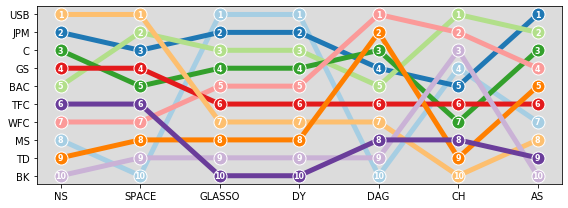

In [65]:
# Run the visualisation function
rank_viz(varnames,ranking_df,centrality_type,date,ts_type)

# Wrapper to generate all scenarios

In [66]:
# Parameters
varnames = ["MS","JPM","BAC","C","WFC","GS","USB","TD","BK","TFC"]
#methods = ['NS','SPACE','GLASSO','DY','DAG']
methods = ['NS','SPACE','GLASSO','DY']



# Additional (control) measures
cross_holdings = True
asset_sizes = True
if cross_holdings:
    CH_network = CH_network
else:
    CH_network = None
    
if asset_sizes:
    varnames_sorted_by_asset = varnames_sorted_by_asset
else:
    varnames_sorted_by_asset = None
    

dy_threshold = 5

# Iterables
dates = ["2020-03-16"]#,"2020-06-30"]
ts_types = ["return","return_factor_resid","volatility","volatility_factor_resid"]
centrality_types = ["eigenvector","betweenness","degree","closeness"] #"eigenvector",

Time series: return, Centrality measure: eigenvector, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


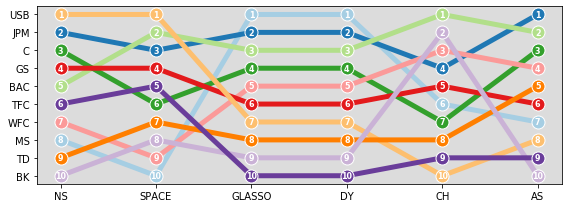

Time series: return, Centrality measure: betweenness, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


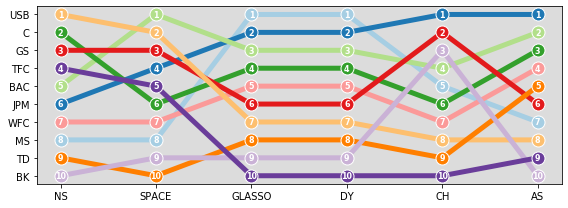

Time series: return, Centrality measure: degree, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


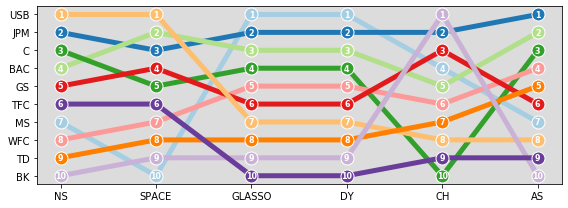

Time series: return, Centrality measure: closeness, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


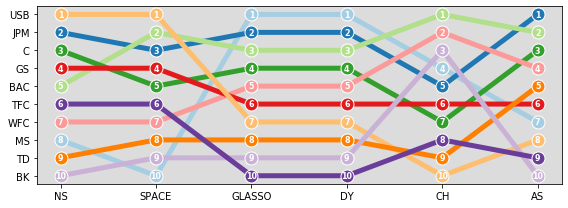

Time series: return_factor_resid, Centrality measure: eigenvector, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


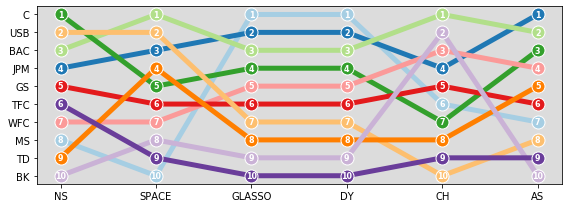

Time series: return_factor_resid, Centrality measure: betweenness, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


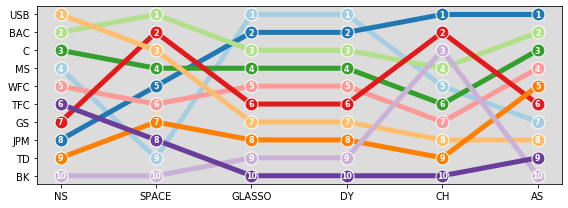

Time series: return_factor_resid, Centrality measure: degree, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


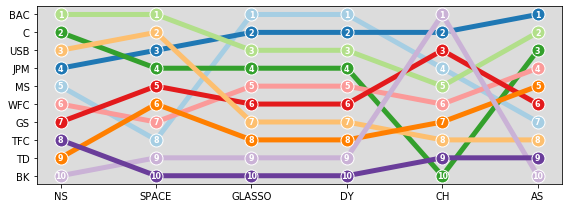

Time series: return_factor_resid, Centrality measure: closeness, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


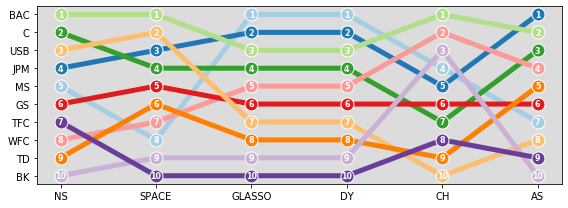

Time series: volatility, Centrality measure: eigenvector, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


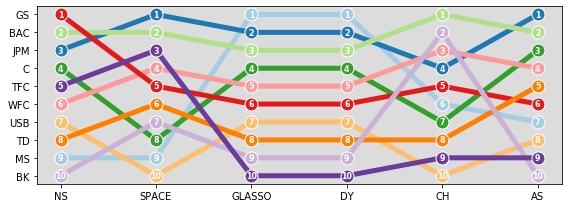

Time series: volatility, Centrality measure: betweenness, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


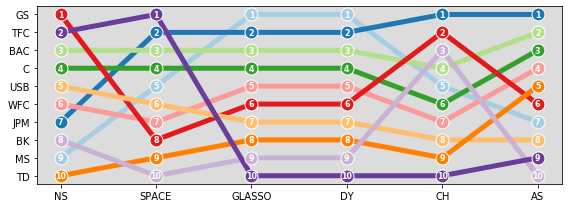

Time series: volatility, Centrality measure: degree, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


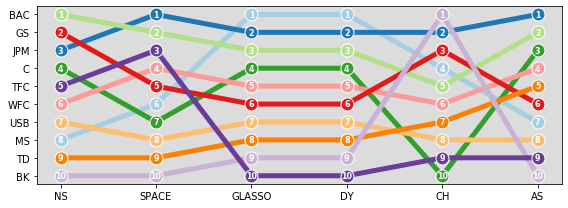

Time series: volatility, Centrality measure: closeness, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


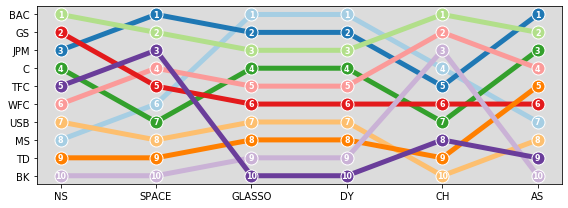

Time series: volatility_factor_resid, Centrality measure: eigenvector, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


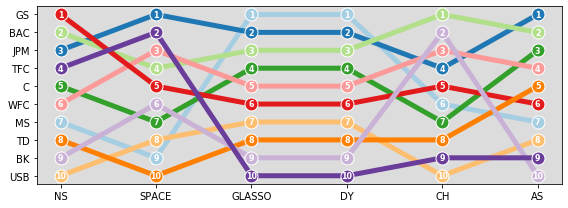

Time series: volatility_factor_resid, Centrality measure: betweenness, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


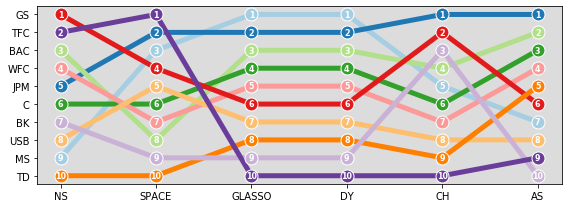

Time series: volatility_factor_resid, Centrality measure: degree, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


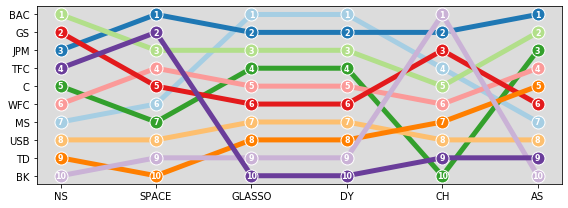

Time series: volatility_factor_resid, Centrality measure: closeness, Date: 2020-03-16
NS
SPACE
GLASSO
DY
CH


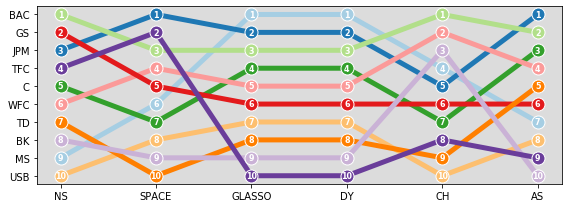

In [67]:
# Run the wrapper function
for date in dates:
    for ts_type in ts_types:
        for centrality_type in centrality_types:
            
            print("Time series: {}, Centrality measure: {}, Date: {}".format(ts_type,centrality_type,date))
            
            workflow_wrapper_function(date=date,methods=methods,ts_type=ts_type,dy_threshold=dy_threshold,
                         centrality_type=centrality_type,varnames=varnames,
                        asset_sizes=varnames_sorted_by_asset,cross_holding_network=CH_network)

# Robustness/Persistence checks

In [23]:
# Parameters
dy_threshold = 10.5
dates = ["2020-03-05","2020-06-30"]

# Loop over methods and time series types and check their persistence/flexibility
methods = ['NS','SPACE','GLASSO','DY','DAG']
ts_types = ["return","return_factor_resid","volatility","volatility_factor_resid"]

# Loop over time series types
for ts_type in ts_types:
    
    print(ts_type)
    # Initialize dictionary to store the results
    res = {}
    
    # Loop over methods
    for method in methods:
        
        # Compute flexibility/robustness scores
        score = network_robustness_check(dates,method,ts_type,dy_threshold)
        
        # Add it to the dictionary
        res[method] = round(score,2)
        
    # Display results
    print(res)
    print("----"*5)

return
{'NS': 0.88, 'SPACE': 0.91, 'GLASSO': 0.36, 'DY': 0.46, 'DAG': 2.56}
--------------------
return_factor_resid
{'NS': 0.81, 'SPACE': 0.84, 'GLASSO': 0.36, 'DY': 0.46, 'DAG': 2.53}
--------------------
volatility
{'NS': 0.61, 'SPACE': 0.63, 'GLASSO': 0.32, 'DY': 0.57, 'DAG': 2.01}
--------------------
volatility_factor_resid
{'NS': 0.65, 'SPACE': 0.66, 'GLASSO': 0.31, 'DY': 0.55, 'DAG': 2.0}
--------------------


# Support

In [17]:
date = "2020-03-05"
method = "DY"
date = "2020-06-30"
ts_type = "return"
dy_threshold = 10.5

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DAG']

temp = network_preprocessing(date,method,ts_type)

In [15]:

date = "2020-03-05"
final_date_transformed = date.replace("-","_")
method = "DY"
ts_type = "return"

filename = "./Data/Estimated_networks/" +\
                  method+"_"+ts_type+"_"+final_date_transformed+".csv"

NE_estimated_matrix = np.genfromtxt(filename,
                              delimiter=',',skip_header = 1,usecols = np.arange(1,11),
                                   skip_footer=1)

print(NE_estimated_matrix.shape)
print(NE_estimated_matrix)

CH_G = nx.from_numpy_matrix(NE_estimated_matrix, create_using=nx.DiGraph)

(10, 10)
[[16.2  10.78 11.4  11.37  8.15 11.94  9.15  6.58  5.83  8.6 ]
 [ 9.54 14.49 12.07 11.52  8.41 10.36 10.66  6.6   6.58  9.76]
 [10.03 11.59 13.63 11.36  8.58 10.24 10.75  6.97  7.12  9.72]
 [10.19 11.81 11.98 14.38  8.42 10.59  9.53  7.    6.9   9.2 ]
 [ 9.01 10.51 11.13 10.14 16.98  9.01 10.71  6.33  6.19  9.99]
 [11.35 11.28 11.45 11.23  7.97 15.26  9.18  6.89  6.16  9.23]
 [ 8.9  11.47 11.83 10.11  8.94  9.12 15.3   6.43  6.87 11.03]
 [ 9.18  9.61 10.92  9.98  7.43  9.45  9.31 19.93  5.72  8.48]
 [ 7.39 10.   10.89 10.33  7.05  8.68  9.66  5.24 22.67  8.1 ]
 [ 8.74 11.03 11.31 10.18  9.03  9.58 11.85  6.46  5.88 15.95]]
